In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

In [2]:
!python create_data.py

In [5]:
train_dir = 'F:\\FYP-23_Novel_AI_Therapy\\Real-Time Image Detection\\train'
test_dir = 'F:\\FYP-23_Novel_AI_Therapy\\Real-Time Image Detection\\test'

row = 48
col = 48
classes = len(os.listdir('F:\\FYP-23_Novel_AI_Therapy\\Real-Time Image Detection\\train'))

In [6]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t\t", len(os.listdir(train_dir+"\\"+folder)), "image")
    train_count.append(len(os.listdir(train_dir+"\\"+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+"\\"+folder)), "images")
    test_count.append(len(os.listdir(test_dir+"\\"+folder)))

Train Set :
angry folder contains			 3995 image
disgust folder contains			 436 image
fear folder contains			 4097 image
happy folder contains			 7215 image
neutral folder contains			 4965 image
sad folder contains			 4830 image
surprise folder contains			 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [9]:
classnames = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"] # These classes should be folder names

In [10]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
fernet = get_model((row,col,1), classes)

In [12]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [26]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=60,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - 529s 1s/step - loss: 3.7024 - accuracy: 0.3240 - val_loss: 3.3994 - val_accuracy: 0.3894

Epoch 00001: val_loss improved from inf to 3.39943, saving model to ferNet.h5
Epoch 2/60
448/448 [==============================] - 531s 1s/step - loss: 3.1338 - accuracy: 0.3694 - val_loss: 2.8097 - val_accuracy: 0.4261

Epoch 00002: val_loss improved from 3.39943 to 2.80972, saving model to ferNet.h5
Epoch 3/60
448/448 [==============================] - 533s 1s/step - loss: 2.6898 - accuracy: 0.3985 - val_loss: 2.4210 - val_accuracy: 0.4562

Epoch 00003: val_loss improved from 2.80972 to 2.42095, saving model to ferNet.h5
Epoch 4/60
448/448 [==============================] - 530s 1s/step - loss: 2.3448 - accuracy: 0.4263 - val_loss: 2.1529 - val_accuracy: 0.4609

Epoch 00004: val_loss improved from 2.42095 to 2.15291, saving model to ferNet.h5
Epoch 5/60
448/448 [==============================] - 533s 1s/step - loss: 2.0768 - accuracy: 0.4516

In [ ]:
fernet.save("Realtime_CNN_Model.h5")

### Representing model accuracy graphically

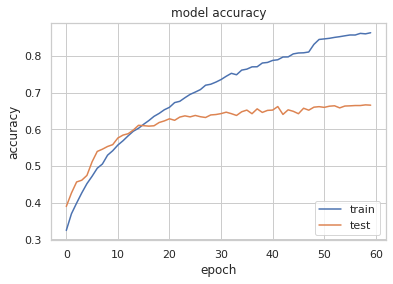

In [30]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

### Representing model loss graphically

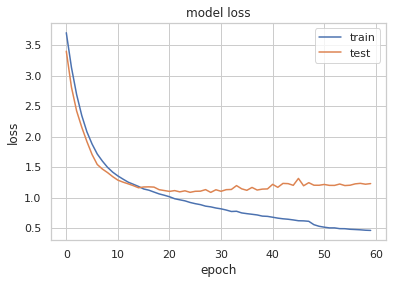

In [32]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
model = tf.keras.models.load_model('ferNet.h5')

### Getting Final Train Accuracy and Validation Accuracy

In [14]:
train_loss, train_accu = model.evaluate(training_set)
test_loss, test_accu = model.evaluate(test_set) 
print("Final train accuracy = {:.2f} , Validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 138s 1s/step - loss: 1.0849 - accuracy: 0.6390
Final train accuracy = 80.16 , Validation accuracy = 63.90


### Confusion Matrix

In [14]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)

449/449 [==============================] - 150s 333ms/step
Confusion Matrix
[[ 483   42  525 1063  800  675  407]
 [  61    4   47  122   77   79   46]
 [ 513   50  540 1068  785  727  414]
 [ 907   72  983 1867 1329 1320  737]
 [ 637   54  651 1320  961  855  487]
 [ 563   57  622 1308  943  802  535]
 [ 382   33  418  859  589  569  321]]


In [15]:
print('Classification Report\n')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

Classification Report

              precision    recall  f1-score   support

       angry       0.14      0.12      0.13      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.13      0.14      4097
       happy       0.25      0.26      0.25      7215
     neutral       0.18      0.19      0.18      4965
         sad       0.16      0.17      0.16      4830
    surprise       0.11      0.10      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



In [84]:
image = cv2.imread('E:\\Final_Year_Project\\Real-Time Image Detection\\I3.jpg', cv2.IMREAD_GRAYSCALE)

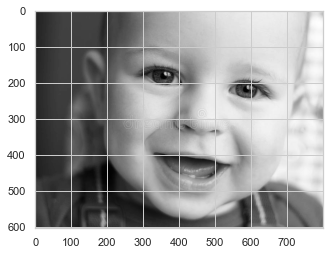

In [85]:
plt.imshow(image,cmap='gray')
plt.show()

In [86]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=model.predict(img) 
result=np.argmax(predict_x,axis=1)
classnames[result[0]]

1/1 [==============================] - 0s 48ms/step


'happy'

In [17]:
Data_dir = r"F:\\FYP-23_Novel_AI_Therapy\\Real-Time Image Detection\\Face_Data\\"
import glob

In [18]:
ext = ['png', 'jpeg', 'jpg']    # Add image formats here
files = []
[files.extend(glob.glob(Data_dir + '*.' + e)) for e in ext]
images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in files]
print(len(images))

99


In [19]:
img_out = []
for i in range(len(images)):
    img_out.append(images[i])

In [1]:
len(img_out)
pred_out = []

NameError: name 'img_out' is not defined

In [21]:
def img_size(image):
    image = cv2.resize(image,(48,48))
    img=np.array(image)
    img=img.reshape(1,48,48,1)
    pred_out.append(model.predict(img)) 

In [22]:
for i in range(len(img_out)):
    img_size(img_out[i])

1/1 [==============================] - 0s 42ms/step


In [23]:
pred_scores = []
for i in range(len(pred_out)):
    pred_scores.append(np.argmax(pred_out[i],axis=1))

In [24]:
sent_out = []
for i in range(len(pred_scores)):
    sent_out.append(classnames[pred_scores[i][0]])

In [39]:
# print(sent_out)
print(len(sent_out))

99


In [40]:
dc = 0  # negative emotion count
hc = 0  # positive emotion count
suc = 0 # surprise count

In [41]:
for i in range(len(sent_out)):
  if(sent_out[i] == 'angry' or sent_out[i] == 'disgust' or sent_out[i] == 'sad' or sent_out[i] == 'fear'):
      dc += 1
  elif (sent_out[i] == 'happy' or sent_out[i] == 'neutral'):
      hc += 1
  elif (sent_out[i] == 'surprise'):
      suc += 1
print("Sad Emotions : ", dc)
print("Happy Emotions : ", hc)
print("Surprise Emotions : ", suc)

Sad Emotions :  10
Happy Emotions :  74
Surprise Emotions :  15


In [67]:
pos_rate = round((hc / (dc + hc + suc)), 2) * 100
neg_rate = round((dc / (dc + hc + suc)), 2) * 100

In [45]:
print("\nNegative emotions : ", neg_rate, "%")
print("\nPositive emotions : ", pos_rate, "%")


Negative emotions :  10.0 %

Positive emotions :  75.0 %


In [68]:
if (neg_rate <= 30.0):
  print("***   MILD DEPRESSION  ***")

  if (neg_rate <= 10.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tEverything is a-okay! There's absolutely nothing wrong 😁😁\n\t\tYou're probably cuddling a fluffy kitten right now")
  
  elif (neg_rate > 10.0 and neg_rate <= 20.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are a bit frustated and disappointed\n\t\tBut you're easily distracted and cheered with little effort 😁😁")
  
  elif (neg_rate > 20.0 and neg_rate <= 30.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tThings are bothering you but you're coping up\n\t\tYou might be over tired and hungry\n\t\tThe emotional equivalent of a headache 😁😁")
  
elif (neg_rate > 30.0 and neg_rate <= 60.0):
  print("***   MODERATE DEPRESSION  ***")
  
  if (neg_rate > 30.0 and neg_rate <= 40.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tToday is slighly a bad for you.\n\t\tYou still have the skills to get through it, but be gentle with yourself\n\t\tUse self-care strategies 😁😁")

  elif (neg_rate > 40.0 and neg_rate <= 50.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYour mental health is starting to impact your everyday life.\n\t\tEasy things are becoming difficult")
  
  elif (neg_rate > 50.0 and neg_rate <= 60.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are not able to do things the way usually you do them due to your mental health.\n\t\tImpulsive and compulsive thoughts might be difficult to cope with")
  
elif (neg_rate > 60.0 and neg_rate <= 100.0):
  print("***   SEVERE DEPRESSION  ***")
  if (neg_rate > 60.0 and neg_rate <= 70.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are loosing interests in the activities that were used to be enjoyable.\n\t\tYou should definitely seek help\n\t\tThis is becoming serious ☹☹")
  
  elif (neg_rate > 70.0 and neg_rate <= 80.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou can't ignore your struggles now, It's HIGH time!.\n\t\tYou may have issues sleeping, eating, having fun, socializing and work/study\n\t\tYour mental health is affecting almost all parts of your life ☹☹")

  elif (neg_rate > 80.0 and neg_rate <= 90.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tYou are at a critical point !!!.\n\t\tYou aren't functioning anymore and need urgent help.\n\t\tYou maybe a risk to yourself or others if left untreated ☹☹")

  elif (neg_rate > 90.0 and neg_rate <= 100.0):
    print("\nDepression Scale Detected : ", round(neg_rate) / 10,"\n")
    print("My Response :\tThe worst mental and emotional distress possible.\n\t\tYou can't imagine things getting any better now and you might think it's all over for you (SUICIDE).\n\t\tContact crisis line or get started for the treatment immediately. ☹☹")

  

***   SEVERE DEPRESSION  ***

Depression Scale Detected :  8.2 

My Response : You are at a critical point !!!.
		 You aren't functioning anymore and need urgent help.
		 You maybe a risk to yourself or others if left untreated ☹☹
